In [894]:
import cv2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [895]:
face_cascade = cv2.CascadeClassifier('../Data/haarcascade_frontalface_default.xml')

In [896]:
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Detect face
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w] # Crop to face region
                        images.append(face_region)
                        labels.append(label)
    return images, labels

In [897]:
# Define parameters for LBP
radius = 1
n_points = 8 * radius

# Function to extract LBP features from the cropped face images
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        # Resize face image to a standard size if needed
        img = cv2.resize(img, (64, 64)) # Standard size
        lbp = local_binary_pattern(img, n_points, radius, method='uniform')
        # Histogram of LBP patterns
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

In [898]:
def extract_hog_features(images):
    hog_features = []
    # Define HOG parameters
    # Play around with these values later, but these are good starting points:
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    orientations = 8 # Number of orientation bins

    for img in images:
        # 1. Resize/Convert: Ensure consistent size (64x64) and proper type (float)
        img = cv2.resize(img, (64, 64))

        # 2. Compute HOG: output_vector=True returns a single flattened vector
        features = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm='L2-Hys', # Standard normalization scheme
            transform_sqrt=True, # Improves performance
            feature_vector=True
        )
        hog_features.append(features)

    return np.array(hog_features)

In [899]:
# Set paths for training and testing folders
ck_folder_path = "../Data/assignment/CK_dataset"
jaffe_folder_path = "../Data/assignment/jaffe"

ck_images, ck_labels = load_and_detect_faces(ck_folder_path)
# jaffe_images, jaffe_labels = load_and_detect_faces(jaffe_folder_path)

ck_lbp_features = extract_lbp_features(ck_images)
# jaffe_lbp_features = extract_lbp_features(jaffe_images)

ck_hog_features = extract_hog_features(ck_images)
# jaffe_hog_features = extract_hog_features(jaffe_images)
#
# all_lbp_features = np.concatenate((ck_lbp_features, jaffe_lbp_features), axis=0)
# all_hog_features = np.concatenate((ck_hog_features, jaffe_hog_features), axis=0)
#
# x = n.concatenate((all_lbp_features, all_hog_features), axis=1)
# y = np.array(ck_labels + jaffe_labels)

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((ck_lbp_features, ck_hog_features), axis=1), ck_labels, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test = train_test_split(np.concatenate((jaffe_lbp_features, jaffe_hog_features), axis=1), jaffe_labels, test_size=0.2, random_state=42)

In [900]:
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [901]:
# from sklearn.neighbors import KNeighborsClassifier
#
# k = 15
#
# # knn = KNeighborsClassifier(5) # Define classifier
# knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k)) # Define classifier
# knn.fit(x_train, y_train) # Train model
#
# # Make predictions
# y_train_pred = knn.predict(x_train)
# y_test_pred = knn.predict(x_test)
#
# # Training set performance
# knn_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
# knn_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
# knn_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
#
# # Test set performance
# knn_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
# knn_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
# knn_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
#
# print('Model performance for Training set')
# print('- Accuracy: %s' % knn_train_accuracy)
# print('- MCC: %s' % knn_train_mcc)
# print('- F1 score: %s' % knn_train_f1)
# print('----------------------------------')
# print('Model performance for Test set')
# print('- Accuracy: %s' % knn_test_accuracy)
# print('- MCC: %s' % knn_test_mcc)
# print('- F1 score: %s' % knn_test_f1)

In [902]:
# conf_matrix = confusion_matrix(y_test, y_test_pred)
# print(len(y_test))
# print(conf_matrix)

In [903]:
n_components = 1

svm_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.1, gamma='auto')
)
svm_rbf.fit(x_train, y_train)

# Make predictions
y_train_pred = svm_rbf.predict(x_train)
y_test_pred = svm_rbf.predict(x_test)

# Training set performance
svm_rbf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
svm_rbf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
svm_rbf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
svm_rbf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
svm_rbf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
svm_rbf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % svm_rbf_train_accuracy)
print('- MCC: %s' % svm_rbf_train_mcc)
print('- F1 score: %s' % svm_rbf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % svm_rbf_test_accuracy)
print('- MCC: %s' % svm_rbf_test_mcc)
print('- F1 score: %s' % svm_rbf_test_f1)

Model performance for Training set
- Accuracy: 0.8989637305699482
- MCC: 0.8755984984206217
- F1 score: 0.8890115768477538
----------------------------------
Model performance for Test set
- Accuracy: 0.6494845360824743
- MCC: 0.5911742438183804
- F1 score: 0.6277074726264326


In [904]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

97
[[ 4  0  0  6  1  0]
 [ 0  0  1  5  2  2]
 [ 0  0 17  3  0  0]
 [ 0  0  0 16  0  1]
 [ 0  0  0  5  4  1]
 [ 0  0  0  7  0 22]]


In [905]:
# from sklearn.tree import DecisionTreeClassifier
#
# dt = DecisionTreeClassifier(max_depth=5) # Define classifier
# dt.fit(x_train, y_train) # Train model
#
# # Make predictions
# y_train_pred = dt.predict(x_train)
# y_test_pred = dt.predict(x_test)
#
# # Training set performance
# dt_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
# dt_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
# dt_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
#
# # Test set performance
# dt_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
# dt_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
# dt_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
#
# print('Model performance for Training set')
# print('- Accuracy: %s' % dt_train_accuracy)
# print('- MCC: %s' % dt_train_mcc)
# print('- F1 score: %s' % dt_train_f1)
# print('----------------------------------')
# print('Model performance for Test set')
# print('- Accuracy: %s' % dt_test_accuracy)
# print('- MCC: %s' % dt_test_mcc)
# print('- F1 score: %s' % dt_test_f1)

In [906]:
rf = rf = RandomForestClassifier(max_depth=8, min_samples_leaf=16, random_state=42) # Define classifier
rf.fit(x_train, y_train) # Train model

# Make predictions
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)

# Training set performance
rf_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
rf_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
rf_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set performance
rf_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
rf_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
rf_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % rf_train_accuracy)
print('- MCC: %s' % rf_train_mcc)
print('- F1 score: %s' % rf_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % rf_test_accuracy)
print('- MCC: %s' % rf_test_mcc)
print('- F1 score: %s' % rf_test_f1)

Model performance for Training set
- Accuracy: 0.772020725388601
- MCC: 0.7190656613781233
- F1 score: 0.7546658873442035
----------------------------------
Model performance for Test set
- Accuracy: 0.6391752577319587
- MCC: 0.5944682817603453
- F1 score: 0.5904100120490074


In [907]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

97
[[ 1  0  0  9  1  0]
 [ 0  0  4  6  0  0]
 [ 0  0 19  1  0  0]
 [ 0  0  0 17  0  0]
 [ 0  0  0  8  2  0]
 [ 0  0  0  6  0 23]]


In [908]:
# from sklearn.neural_network import MLPClassifier
#
# mlp = MLPClassifier(alpha=1, max_iter=1000)
# mlp.fit(x_train, y_train)
#
# # Make predictions
# y_train_pred = mlp.predict(x_train)
# y_test_pred = mlp.predict(x_test)
#
# # Training set performance
# mlp_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
# mlp_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
# mlp_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
#
# # Test set performance
# mlp_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
# mlp_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
# mlp_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
#
# print('Model performance for Training set')
# print('- Accuracy: %s' % mlp_train_accuracy)
# print('- MCC: %s' % mlp_train_mcc)
# print('- F1 score: %s' % mlp_train_f1)
# print('----------------------------------')
# print('Model performance for Test set')
# print('- Accuracy: %s' % mlp_test_accuracy)
# print('- MCC: %s' % mlp_test_mcc)
# print('- F1 score: %s' % mlp_test_f1)

In [909]:
estimator_list = [
    # ('knn',knn),
    ('svm_rbf',svm_rbf),
    # ('dt',dt),
    ('rf',rf),
    # ('mlp',mlp)
    ]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list,
    # Tightly constrain the blender to only learn simple linear weights
    final_estimator=LogisticRegression(C=0.2, solver='liblinear', random_state=42)
)

# Train stacked model
stack_model.fit(x_train, y_train)

# Make predictions
y_train_pred = stack_model.predict(x_train)
y_test_pred = stack_model.predict(x_test)

# Training set model performance
stack_model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
stack_model_train_mcc = matthews_corrcoef(y_train, y_train_pred) # Calculate MCC
stack_model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score

# Test set model performance
stack_model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
stack_model_test_mcc = matthews_corrcoef(y_test, y_test_pred) # Calculate MCC
stack_model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score

print('Model performance for Training set')
print('- Accuracy: %s' % stack_model_train_accuracy)
print('- MCC: %s' % stack_model_train_mcc)
print('- F1 score: %s' % stack_model_train_f1)
print('----------------------------------')
print('Model performance for Test set')
print('- Accuracy: %s' % stack_model_test_accuracy)
print('- MCC: %s' % stack_model_test_mcc)
print('- F1 score: %s' % stack_model_test_f1)

Model performance for Training set
- Accuracy: 0.8601036269430051
- MCC: 0.8240042467663549
- F1 score: 0.8455129147432691
----------------------------------
Model performance for Test set
- Accuracy: 0.6494845360824743
- MCC: 0.5824338835292404
- F1 score: 0.6204962209813635


C:\Users\sarah\source\repos\UCLan_ArtificialIntelligence\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [910]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(len(y_test))
print(conf_matrix)

97
[[ 4  0  0  6  1  0]
 [ 0  0  2  4  2  2]
 [ 0  0 18  2  0  0]
 [ 0  0  1 15  0  1]
 [ 0  0  0  5  4  1]
 [ 0  0  1  6  0 22]]


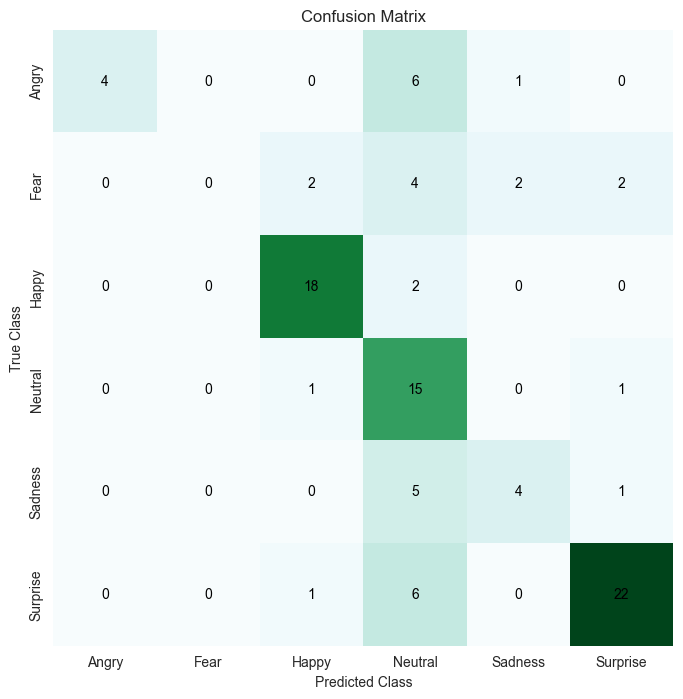

In [911]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming class names are defined
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Plot confusion matrix with class names
plt.figure(figsize=(8,8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)

# Add annotations with both counts and percentages
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [912]:
acc_train_list = {
    # 'knn':knn_train_accuracy,
'svm_rbf': svm_rbf_train_accuracy,
# 'dt': dt_train_accuracy,
'rf': rf_train_accuracy,
# 'mlp': mlp_train_accuracy,
'stack': stack_model_train_accuracy}

mcc_train_list = {
    # 'knn':knn_train_mcc,
'svm_rbf': svm_rbf_train_mcc,
# 'dt': dt_train_mcc,
'rf': rf_train_mcc,
# 'mlp': mlp_train_mcc,
'stack': stack_model_train_mcc}

f1_train_list = {
    # 'knn':knn_train_f1,
'svm_rbf': svm_rbf_train_f1,
# 'dt': dt_train_f1,
'rf': rf_train_f1,
# 'mlp': mlp_train_f1,
'stack': stack_model_train_f1}

acc_test_list = {
    # 'knn':knn_test_accuracy,
'svm_rbf': svm_rbf_test_accuracy,
# 'dt': dt_test_accuracy,
'rf': rf_test_accuracy,
# 'mlp': mlp_test_accuracy,
'stack': stack_model_test_accuracy}

mcc_test_list = {
    # 'knn':knn_test_mcc,
'svm_rbf': svm_rbf_test_mcc,
# 'dt': dt_test_mcc,
'rf': rf_test_mcc,
# 'mlp': mlp_test_mcc,
'stack': stack_model_test_mcc}

f1_test_list = {
    # 'knn':knn_test_f1,
'svm_rbf': svm_rbf_test_f1,
# 'dt': dt_test_f1,
'rf': rf_test_f1,
# 'mlp': mlp_test_f1,
'stack': stack_model_test_f1}

In [913]:
acc_df_train = pd.DataFrame.from_dict(acc_train_list, orient='index', columns=['Accuracy Train'])
mcc_df_train = pd.DataFrame.from_dict(mcc_train_list, orient='index', columns=['MCC Train'])
f1_df_train = pd.DataFrame.from_dict(f1_train_list, orient='index', columns=['F1 Train'])
acc_df_test = pd.DataFrame.from_dict(acc_test_list, orient='index', columns=['Accuracy Test'])
mcc_df_test = pd.DataFrame.from_dict(mcc_test_list, orient='index', columns=['MCC Test'])
f1_df_test = pd.DataFrame.from_dict(f1_test_list, orient='index', columns=['F1 Test'])
df = pd.concat([acc_df_train, mcc_df_train, f1_df_train, acc_df_test, mcc_df_test, f1_df_test], axis=1)
df

,Accuracy Train,MCC Train,F1 Train,Accuracy Test,MCC Test,F1 Test
svm_rbf,0.898964,0.875598,0.889012,0.649485,0.591174,0.627707
rf,0.772021,0.719066,0.754666,0.639175,0.594468,0.590410
stack,0.860104,0.824004,0.845513,0.649485,0.582434,0.620496


In [914]:
df.to_csv('results.csv')